## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
# import nuctools

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [4]:
### calc calculate a full energy grid yourself 
energy_grid = [75, 125]
energy_grid = [1.0, 24]

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = {'Add Noise': True,
            'Calculate Covariance': True,
            'Sample TURP': False}

experiment_parameters = {'bw': {'val':0.8192,    'unc'   :   0}} #,
                        #  'trigo': {'val':1e9,    'unc'   :   0},
                        #  'trigs': {'val':1e9,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

2472

In [5]:
spin_groups = [ (3.0,1,0) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':4.17, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })
                                    
                                    
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

resonance_ladder

,E,Gg,gn2,J,chs,lwave,J_ID
0,4.900369,63.224922,1.335158,3.0,1.0,0.0,1.0
1,9.094818,65.570442,0.664146,3.0,1.0,0.0,1.0
2,15.021705,65.638516,0.892375,3.0,1.0,0.0,1.0
3,17.171618,63.185887,36.345259,3.0,1.0,0.0,1.0
4,21.466856,59.240763,67.320430,3.0,1.0,0.0,1.0


In [6]:
# resonance_ladder.to_csv('./UPR_presentation_ladder.csv')

In [7]:
# jb_df = pd.read_csv('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv', index_col=0)

# energy_grid = [10, 50000]
# # initialize experimental setup
# exp = Experiment(energy_grid, 
#                         input_options=input_options, 
#                         experiment_parameters=experiment_parameters)
# # energy_grid = np.linspace(min(jb_df.e),max(jb_df.e),5000)
# energy_grid = np.linspace(5e5,1e6,10000)
# # energy_grid = jb_df.e
# # energy_grid = exp.energy_domain

# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
# theo = sammy_interface.calculate_xs(energy_grid, resonance_ladder, Ta_pair,
#                                             model = 'XCT',
#                                             expertimental_corrections = 'no_exp',
#                                             sammy_runDIR = 'SAMMY_runDIR',
#                                             keep_runDIR=True,
#                                             one_spingroup = False    
#                                             )

In [8]:
# fig, axes = subplots(2,2, figsize=(10,4), sharex=True)

# axes[0,0].scatter(jb_df.e, jb_df.trans, s=4)
# # axes[0,0].plot(theo.E, theo.theo_trans)
# axes[0,0].set_ylim([-0.1, 1.1])

# scatter(jb_df.e, jb_df.trans, s=4)
# axes[0,1].plot(theo.E, theo.theo_xs)
# axes[0,1].set_yscale('log')
# # axes[0,1].scatter(resonance_ladder.E, np.ones(len(resonance_ladder.E))*8.5)

# cumres = [np.count_nonzero(resonance_ladder.E<=elam) for elam in resonance_ladder.E]
# axes[1,0].plot(resonance_ladder.E, cumres)
# axes[1,1].plot(resonance_ladder.E, cumres)
# for ax in axes.flatten():
#     ax.set_xscale('log')

# fig.tight_layout()

### Calculate cross section using SAMMY and run experiment

In [10]:
# theo = sammy_interface.calculate_xs(exp.energy_domain, resonance_ladder, Ta_pair,
#                                             model = 'XCT',
#                                             expertimental_corrections = 'all_exp',
#                                             sammy_runDIR = 'SAMMY_runDIR',
#                                             keep_runDIR=True,
#                                             one_spingroup = False    
#                                             )

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'total',
    solve_bayes = False,
    inptemplate= "allexptot_1sg.inp",
    one_spingroup = True,
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_1',
    keep_runDIR = True,
    shell = 'zsh'
    )

# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
resonance_ladder = pd.DataFrame({'E':[4.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})


sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = exp.energy_domain,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

theo, par = sammy_functions.run_sammy(sammyINP, sammyRTO)

# sammyRTO.sammy_runDIR = 'SAMMY_runDIR_2'
# sammyINP.resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[160], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# theo1, par1 = sammy_functions.run_sammy(sammyINP, sammyRTO)


# from ATARI.theory.experimental import xs_2_trans, trans_2_xs
# theo2trans = xs_2_trans(theo.theo_xs , 0.067166)
# theo2xs, _ = trans_2_xs(theo.theo_trans, 0.067166, n_unc=0.0, CovT=None)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG\n'


In [11]:
np.any(np.isinf(theo.theo_xs))

True

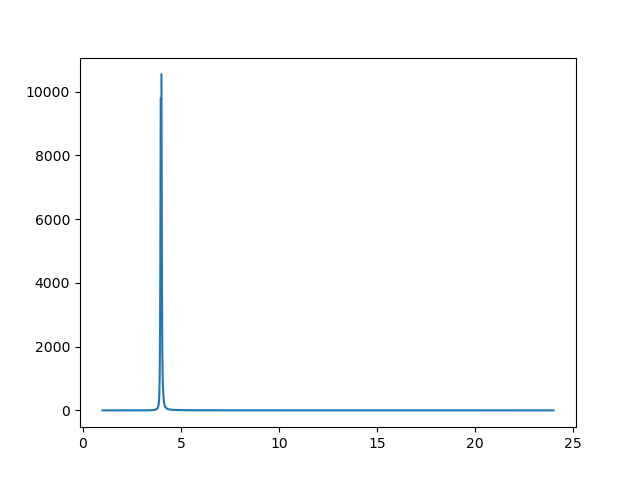

In [12]:
figure()
# plot(theo.E, theo.theo_xs/theo1.theo_xs)
plot(theo.E, theo.theo_xs)
# plot(theo.E, theo1.theo_xs)

In [13]:
resonance_ladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,4.0,7.0,4.0,3,1,0,1


In [14]:
# sammyINP.resonance_ladder = resonance_ladder.iloc[7,:].to_frame().T
theo1, par1 = sammy_functions.run_sammy(sammyINP, sammyRTO)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG\n'


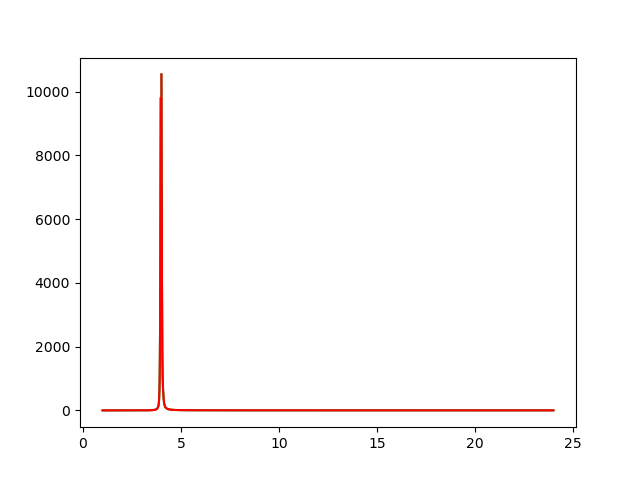

In [15]:
figure()
# plot(theo.E, theo2trans-theo.theo_trans, 'r')
# plot(theo.E,theo2xs-theo.theo_xs)
# plot(theo.E, theo2xs, 'r')
plot(theo.E, theo.theo_xs, 'g')
plot(theo1.E, theo1.theo_xs.values, 'r')


In [16]:

exp.run(theo)
# exp.redpar - exp.theo_redpar

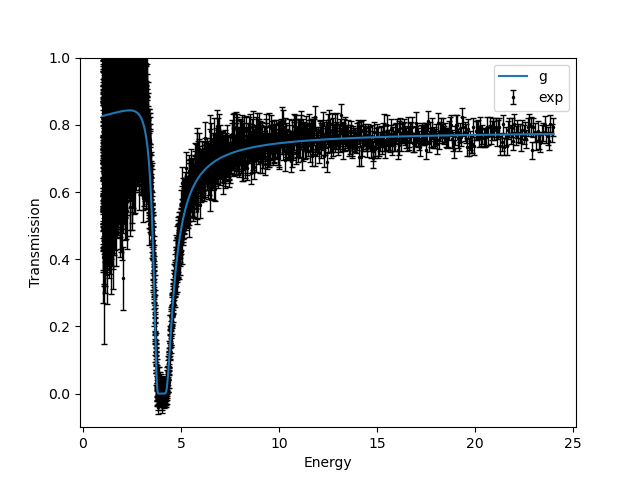

In [17]:
figure()
plot(theo.E, theo.theo_trans, ms=1, label='g')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

In [18]:
from ATARI.utils.datacontainer import DataContainer
d = DataContainer()
d.add_theoretical(Ta_pair, resonance_ladder)
d.add_experimental(exp)
d.fill()

AttributeError: 'Series' object has no attribute 'gn2'

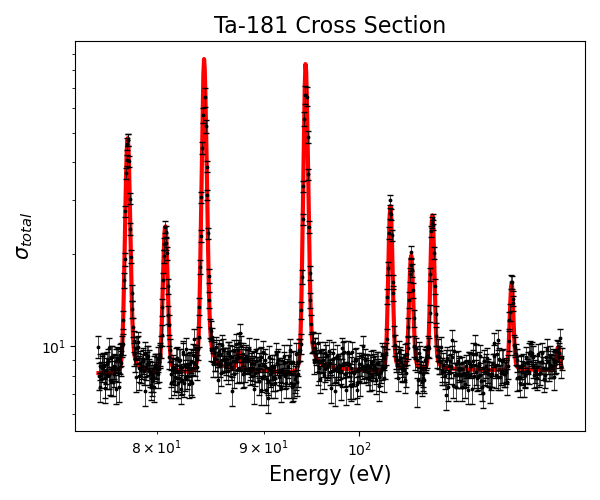

In [ ]:
figure(figsize=(6,5))

errorbar(d.pw_exp.E, d.pw_exp.exp_xs, yerr=d.pw_exp.exp_xs_unc, zorder=2,
                                fmt='.', color='k', ecolor='k', linewidth=0.5, markersize=3.5, capsize=2, label='exp')


plot(theo.E, theo.theo_xs, color='r', zorder=0, lw=3)

# xlim([2501,2990])
yscale('log')
xscale('log')
ylabel(r'$\sigma_{total}$', fontsize=15)
xlabel('Energy (eV)', fontsize=15)
title('Ta-181 Cross Section', fontsize=16)

tight_layout()